In [279]:
location = 'C:/Users/user/Desktop/saltlux/project/project_second/smart_card/'

In [280]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as mpl
import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium.plugins import MarkerCluster
import scipy.stats

In [281]:
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.float_format = '{:.5f}'.format

In [282]:
# 그래프 속성
mpl.rc('font', family = 'Malgun Gothic')
mpl.rc('axes', unicode_minus = False)

In [ ]:
rawdata = pd.read_csv(location + 'filename.csv', encoding = 'euc-kr')
rawdata.head()

In [ ]:
rawdata.info()

## 전처리
* 출발지와 도착지가 동일한 사람들을 제거 (환승을 이용해서 원위치로 돌아오는 사람들 + 타자마자 카드를 찍어서 하차로 남는 경우들)
* Circuity 값이 너무 높은 사람들은 제거해야 한다 (추후 환승이 circuity에 미치는 영향을 조사하기 위해서)

In [ ]:
rawdata[rawdata['on_area_name'] == rawdata['off_area_name']].info()

In [286]:
#출발지와 도착지가 똑같은 데이터는 제거
df_mobility = rawdata[~(rawdata['on_area_name'] == rawdata['off_area_name'])]

In [ ]:
df_mobility.info()

* Circuity 이상치 제거 (무한대 값과 0값이 포함되어있음)
* 역 이름으로는 미처 제거되지 못한 원자리로 돌아오는 데이터가 아직 남아있음
* Haversine이 0이기 때문에 무한대 값이 생겨버림
* Total_Distance 값이 0인 경우가 있음. 이런 경우 Circuityr가 0이 되어버린다. 마찬가지로 제거

In [ ]:
df_mobility['Circuity'].describe()

In [ ]:
df_mobility[df_mobility['Circuity'] == np.inf].info()

In [ ]:
df_mobility[df_mobility['Circuity'] == 0].info()

In [291]:
df_mobility1 = df_mobility[~(df_mobility['Circuity'] == 0) & ~(df_mobility['Circuity'] == np.inf)]

In [ ]:
df_mobility1.describe()

In [293]:
# 마지막으로 iqr 이상치 제거를 통해서 Circuity가 너무 높은 값들은 제거한다.
iqr = df_mobility1['Circuity'].quantile(0.75) - df_mobility1['Circuity'].quantile(0.25)
iqr

0.2674461090752107

In [ ]:
df_mobility1[~((df_mobility1['Circuity'] > df_mobility1['Circuity'].quantile(0.25) - 1.5*iqr) & (df_mobility1['Circuity'] < df_mobility1['Circuity'].quantile(0.75) + 1.5*iqr))].info()

In [295]:
df_pre_com = df_mobility1[(df_mobility1['Circuity'] > df_mobility1['Circuity'].quantile(0.25) - 1.5*iqr) & (df_mobility1['Circuity'] < df_mobility1['Circuity'].quantile(0.75) + 1.5*iqr)]

In [ ]:
df_pre_com.info()

In [ ]:
#Circuity의 중앙값과 평균이 크게 차이나지 않는다
df_pre_com.describe()

 ### 1. 데이터 시각화를 이용하여 어느 지역에 가장 많은 인구가 승차하는지, 하차하는지, 이용하는 지역을 볼 수 있다

In [298]:
latitude = 37.5560526
longitude = 126.9667922

In [299]:
wt_lat = df_pre_com[(df_pre_com['on_hour'] >= 7) & (df_pre_com['on_hour'] < 9)]['on_lat'].head(10000)
wt_lon = df_pre_com[(df_pre_com['on_hour'] >= 7) & (df_pre_com['on_hour'] < 9)]['on_lon'].head(10000)

In [300]:
wt_lat.head()

22   37.60774
25   37.54874
27   37.43486
33   37.60080
34   37.48810
Name: on_lat, dtype: float64

In [301]:
wt_count = pd.DataFrame(df_pre_com['on_area_name'].value_counts().reset_index())
wt_count.columns = ['station', 'count']
wt_count.head()

,station,count
0,강남역,85059
1,잠실역,72552
2,사당역,64689
3,고속터미널역,63526
4,홍대입구역,54797


In [302]:
wt_count[wt_count['count'] > 10000]['station'].count()

157

In [303]:
top_station = list(wt_count[wt_count['count'] > 10000]['station'])
print(top_station[:5])
print(len(top_station))

['강남역', '잠실역', '사당역', '고속터미널역', '홍대입구역']
157


In [304]:
top_station_lat = [rawdata[rawdata['on_area_name'] == top_station[i]]['on_lat'].iloc[0] for i in tqdm(range(len(top_station)))]
top_station_lon = [rawdata[rawdata['on_area_name'] == top_station[i]]['on_lon'].iloc[0] for i in tqdm(range(len(top_station)))]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [305]:
print(len(top_station_lat))
print(len(top_station_lon))

157
157


In [306]:
#모든 데이터를 지도위에 표시할 수 있는지 테스트
#결론 : 불가
map_f = folium.Map(location = [latitude, longitude],zoom_start = 10, width = 1000, height = 1000)
marker_cluster = MarkerCluster().add_to(map_f)

for lat, lon in tqdm(zip(top_station_lat, top_station_lon)):
    folium.Marker([lat, lon], radius = 1).add_to(marker_cluster)
map_f

0it [00:00, ?it/s]

In [307]:
df_pre_com.columns

Index(['card_name', 'Bus', 'Subway', 'on_area_name', 'on_lon', 'on_lat',
       'on_dong', 'on_hour', 'on_minute', 'on_second', 'off_area_name',
       'off_lon', 'off_lat', 'off_dong', 'off_hour', 'off_minute',
       'off_second', 'no_transfer', 'total_distance', 'total_time', 'route_id',
       'Haversine', 'Circuity'],
      dtype='object')

In [308]:
#출근길 상위 20개 탑승지역
wt_count = pd.DataFrame(df_pre_com[(df_pre_com['on_hour'] >= 7) & (df_pre_com['on_hour'] < 9)]['on_area_name'].value_counts().reset_index())
wt_count.columns = ['station', 'count']
wt_count20 = wt_count.sort_values(by = 'count', ascending = False).head(20)

In [309]:
wt_count20

,station,count
0,사당역,13190
1,신림역,12459
2,잠실역,9045
3,강변역,9000
4,화곡역,8774
5,서울대입구역,8769
6,까치산역,8498
7,연신내역,8125
8,낙성대역,7862
9,광명사거리역,7843


In [310]:
top_station_1 = list(wt_count20['station'])
print(top_station_1[:5])
print(len(top_station_1))

['사당역', '신림역', '잠실역', '강변역', '화곡역']
20


In [311]:
top_station_lat_1 = [df_pre_com[df_pre_com['on_area_name'] == top_station_1[i]]['on_lat'].iloc[0] for i in tqdm(range(len(top_station_1)))]
top_station_lon_1 = [df_pre_com[df_pre_com['on_area_name'] == top_station_1[i]]['on_lon'].iloc[0] for i in tqdm(range(len(top_station_1)))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [312]:
df_pre_com[df_pre_com['on_area_name'] == top_station_1[0]].iloc[0][['on_lat', 'on_lon']].to_list()

[37.476556, 126.981578]

In [313]:
line_number_two = ['신도림역','대림역','구로디지털단지역','신대방역','신림역','봉천역','서울대입구역','낙성대역','사당역']

In [314]:
lines_location = []
for i in line_number_two:
    lines_location.append(df_pre_com[df_pre_com['on_area_name'] == i].iloc[0][['on_lat', 'on_lon']].to_list()) 

In [315]:
lines_location

[[37.50844, 126.891508],
 [37.493301, 126.894954],
 [37.483152, 126.901558],
 [37.48755900000001, 126.913306],
 [37.484247, 126.929731],
 [37.48245900000001, 126.941693],
 [37.48125, 126.952685],
 [37.477071, 126.963508],
 [37.476556, 126.981578]]

In [316]:
line_number_two_hell = ['신림역','봉천역','서울대입구역','낙성대역']

In [317]:
lines_hell_location = []
for i in line_number_two_hell:
    lines_hell_location.append(df_pre_com[df_pre_com['on_area_name'] == i].iloc[0][['on_lat', 'on_lon']].to_list()) 

In [318]:
lines_hell_location

[[37.484247, 126.929731],
 [37.48245900000001, 126.941693],
 [37.48125, 126.952685],
 [37.477071, 126.963508]]

In [319]:
#Folium 위 2호선 특정 라인에 선 그리기
map_f = folium.Map(location = [latitude, longitude],zoom_start = 10, width = 1500, height = 1000)

for lat, lon in tqdm(zip(top_station_lat_1, top_station_lon_1)):
    folium.Marker([lat, lon], radius = 1).add_to(map_f)
    
folium.PolyLine(locations = lines_location).add_to(map_f)
folium.PolyLine(locations = lines_hell_location, color = '#ba1818').add_to(map_f)
map_f

0it [00:00, ?it/s]

In [320]:
map_f.save('final_line_two.html')

In [321]:
#출근길 상위 20개 하차지역
wt_count_off = pd.DataFrame(df_pre_com[(df_pre_com['off_hour'] >= 8) & (df_pre_com['off_hour'] < 10)]['off_area_name'].value_counts().reset_index())
wt_count_off.columns = ['station', 'count']
wt_count_off20 = wt_count_off.sort_values(by = 'count', ascending = False).head(20)

In [322]:
wt_count_off.head()

,station,count
0,강남역,22282
1,역삼역,20406
2,가산디지털단지역,18526
3,삼성역,18208
4,을지로입구역,17096


In [323]:
wt_count_off20.head()

,station,count
0,강남역,22282
1,역삼역,20406
2,가산디지털단지역,18526
3,삼성역,18208
4,을지로입구역,17096


In [324]:
top_station_2 = list(wt_count_off20['station'])
print(top_station_2[:5])
print(len(top_station_2))

['강남역', '역삼역', '가산디지털단지역', '삼성역', '을지로입구역']
20


In [325]:
top_station_lat_2 = [df_pre_com[df_pre_com['off_area_name'] == top_station_2[i]]['off_lat'].iloc[0] for i in tqdm(range(len(top_station_2)))]
top_station_lon_2 = [df_pre_com[df_pre_com['off_area_name'] == top_station_2[i]]['off_lon'].iloc[0] for i in tqdm(range(len(top_station_2)))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [326]:
line_number_two_off = ['교대역','강남역','역삼역','선릉역','삼성역']

In [327]:
lines_location_off20 = []
for i in line_number_two_off:
    lines_location_off20.append(df_pre_com[df_pre_com['off_area_name'] == i].iloc[0][['off_lat', 'off_lon']].to_list()) 

In [328]:
df_pre_com[df_pre_com['off_area_name'] == '교대역']['off_lat']

300       37.49294
348       37.49294
1097      37.49397
1103      37.49397
1174      37.49397
            ...   
8205303   37.49397
8205353   37.49294
8205554   37.49397
8205867   37.49397
8205975   37.49294
Name: off_lat, Length: 46758, dtype: float64

In [329]:
lines_location_off20

[[37.492938, 127.01382],
 [37.498153, 127.028358],
 [37.500672, 127.036468],
 [37.50437, 127.048481],
 [37.508844, 127.062999]]

In [330]:
#출근길 하차 Top 20
map_off_20 = folium.Map(location = [latitude, longitude],zoom_start = 10, width = 1500, height = 1000)

for lat, lon in tqdm(zip(top_station_lat_2, top_station_lon_2)):
    folium.Marker([lat, lon], radius = 1).add_to(map_off_20)
    
folium.PolyLine(locations = lines_location_off20).add_to(map_off_20)

map_off_20

0it [00:00, ?it/s]

In [331]:
map_off_20.save('off_top_20.html')

In [332]:
#퇴근길 상위 20개 탑승지역
ow_count_on = pd.DataFrame(df_pre_com[(df_pre_com['on_hour'] >= 18) & (df_pre_com['on_hour'] < 20)]['on_area_name'].value_counts().reset_index())
ow_count_on.columns = ['station', 'count']
ow_count_on_20 = ow_count_on.sort_values(by = 'count', ascending = False).head(20)

In [333]:
top_station_3 = list(ow_count_on_20['station'])
print(top_station_3[:5])
print(len(top_station_3))

['강남역', '여의도역', '잠실역', '선릉역', '삼성역']
20


In [334]:
top_station_lat_3 = [df_pre_com[df_pre_com['on_area_name'] == top_station_3[i]]['on_lat'].iloc[0] for i in tqdm(range(len(top_station_3)))]
top_station_lon_3 = [df_pre_com[df_pre_com['on_area_name'] == top_station_3[i]]['on_lon'].iloc[0] for i in tqdm(range(len(top_station_3)))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [335]:
#퇴근길 상위 20개 탑승지역
map_f = folium.Map(location = [latitude, longitude],zoom_start = 10, width = 1000, height = 1000)
marker_cluster = MarkerCluster().add_to(map_f)

for lat, lon in tqdm(zip(top_station_lat_3, top_station_lon_3)):
    folium.Marker([lat, lon], radius = 1).add_to(marker_cluster)

map_f

0it [00:00, ?it/s]

In [336]:
#퇴근길 상위 20개 하차지역
ow_count_off = pd.DataFrame(df_pre_com[(df_pre_com['off_hour'] >= 18) & (df_pre_com['off_hour'] < 20)]['off_area_name'].value_counts().reset_index())
ow_count_off.columns = ['station', 'count']
ow_count_off_20 = ow_count_off.sort_values(by = 'count', ascending = False).head(20)

In [337]:
top_station_4 = list(ow_count_on_20['station'])
print(top_station_3[:5])
print(len(top_station_3))

['강남역', '여의도역', '잠실역', '선릉역', '삼성역']
20


In [338]:
top_station_lat_4 = [df_pre_com[df_pre_com['off_area_name'] == top_station_4[i]]['off_lat'].iloc[0] for i in tqdm(range(len(top_station_4)))]
top_station_lon_4 = [df_pre_com[df_pre_com['off_area_name'] == top_station_4[i]]['off_lon'].iloc[0] for i in tqdm(range(len(top_station_4)))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [339]:
#퇴근길 상위 20개 하차지역
map_f = folium.Map(location = [latitude, longitude],zoom_start = 10, width = 1000, height = 1000)
marker_cluster = MarkerCluster().add_to(map_f)

for lat, lon in tqdm(zip(top_station_lat_4, top_station_lon_4)):
    folium.Marker([lat, lon], radius = 1).add_to(marker_cluster)

map_f

0it [00:00, ?it/s]

### 2. Circuity가 낮은 지역을 대중교통 부족 현상이 보여지는 것으로 해석한다

In [ ]:
df_pre_com.info()

In [ ]:
pd.DataFrame(df_pre_com.describe()['Circuity'])

In [346]:
df_pre_com_rein = df_pre_com.reset_index(drop = True)

In [347]:
move = []
length = len(df_pre_com['card_name'])
for i in range(length):
    path = str(df_pre_com_rein['on_dong'][i]) + '_' + str(df_pre_com_rein['off_dong'][i])
    move.append(path)

In [348]:
df_circuity = df_pre_com.copy()

In [349]:
df_circuity['S_E_dong'] = move

In [350]:
df_circuity['Circuity'].mean()

1.2358421102378563

In [351]:
df_circuity_overavg = df_circuity[df_circuity['Circuity'] > df_circuity['Circuity'].mean()] 

In [ ]:
df_circuity_overavg.info()

In [ ]:
df_circuity_overavg.describe()

* 전체 빈도데이터
* 양재 1동 -> 양재 1동 : 양재역에서 인근 주거지역으로 가는 버스를 이용하는 경우가 많다. 셔틀버스 제공 가능
* 휘경 1동 -> 회기동 : 회기역 -> 경의대 의료원(이미 바로 앞까지 가는 마을버스가 있다.)
* 구의 3동 -> 역삼 1동 : 송파구를 돌아서 오는 루트밖에 없다(있긴한데 환승해야됨). 청담대교를 이용한 루트 가능
* 개봉 1동 -> 개봉 1동 : 역에서 주거권으로 들어가는 경우가 많다. 수요가 있을지도 모른다
* 역삼 1동 -> 구의 3동 : 송파구를 돌아서 오는 루트밖에 없다(있긴한데 환승해야됨). 청담대교를 이용한 루트 가능

In [354]:
# 전체 데이터
# 양재 1동 -> 양재 1동 
# 휘경 1동 -> 회기동 
# 구의 3동 -> 역삼 1동 
# 개봉 1동 -> 개봉 1동 
# 역삼 1동 -> 구의 3동 
df_circuity['S_E_dong'].value_counts().head(5)

1123064_1123064    13949
1124077_1123064    10861
1123064_1124077    10687
1122053_1123064     8352
1123064_1120063     8012
Name: S_E_dong, dtype: int64

In [355]:
df_circuity_m = df_circuity_overavg.sort_values(by= 'Circuity', ascending=False).head(1000000)

* 상위 100만개 데이터
* 수궁동 -> 수궁동 : 크게 돌아가진 않는다
* 대학동 -> 낙성대동 : 학교를 한바퀴 돌고 내려가는 경향이 강하기 때문에 길다.
* 전농 1동 -> 전농 1동 : 직선인 경로가 없다8  
* 서교동 -> 신림동 : 지하철을 타면 돌아가긴 하지만 직선거리 버스가 이미 있다
* 구의3동 -> 삼성1동 : 송파구를 돌아서 오는 루트밖에 없다. 청담대교를 이용한 루트 가능

In [356]:
# 상위 100만개 데이터
# 수궁동 -> 수궁동
# 대학동 -> 낙성대동 
# 전농 1동 -> 전농 1동 
# 서교동 -> 신림동 
# 구의3동 -> 삼성1동 
df_circuity_m['S_E_dong'].value_counts().head(5)

1117069_1117069    2642
1121073_1121058    2400
1106083_1106083    2378
1114066_1121069    1825
1105062_1123058    1794
Name: S_E_dong, dtype: int64

### 3. 특정 시간대에 총 이동거리/ 총 이동시간의 비율이 낮아지는 경로는 모빌리티 수요가 있다고 판단한다

In [ ]:
df_pre_com.info()

In [358]:
line_two_on ='신도림역|대림역|구로디지털단지역|신대방역|신림역|봉천역|서울대입구역|낙성대역'
line_two_off ='교대역|강남역|역삼역|선릉역|삼성역'

In [359]:
line_number_two = df_pre_com[(df_pre_com['on_area_name'].str.contains(line_two_on)) & (df_pre_com['off_area_name'].str.contains(line_two_off)) & (df_pre_com['Bus'] == False) & (df_pre_com['Subway'] == True)]

In [ ]:
line_number_two.info()

In [ ]:
line_number_two_nonzero = line_number_two[line_number_two['total_time'] != 0]
line_number_two_nonzero.head()

In [ ]:
line_number_two_nonzero['dt_time'] = line_number_two_nonzero['total_distance'] / (line_number_two_nonzero['total_time']/60)
line_number_two_nonzero.head()

In [363]:
wt_line_two = line_number_two_nonzero[(line_number_two_nonzero['on_hour'] >= 7) & (line_number_two_nonzero['on_hour'] < 9)]

In [364]:
wt_line_two['on_area_name'].value_counts()

신림역         3005
서울대입구역      2498
낙성대역        1933
봉천역         1345
구로디지털단지역    1204
신대방역        1127
신도림역        1039
대림역          862
Name: on_area_name, dtype: int64

In [ ]:
pd.DataFrame(wt_line_two.describe()['dt_time'])

In [366]:
notwt_line_two = line_number_two_nonzero[(line_number_two_nonzero['on_hour'] < 7) | (line_number_two_nonzero['on_hour'] >= 9)]

In [367]:
notwt_line_two['on_area_name'].value_counts()

서울대입구역      4593
신림역         4434
구로디지털단지역    2918
낙성대역        2640
봉천역         1828
신도림역        1609
신대방역        1512
대림역         1289
Name: on_area_name, dtype: int64

In [ ]:
pd.DataFrame(notwt_line_two.describe()['dt_time'])

<AxesSubplot:xlabel='transfer_ys', ylabel='Circuity'>

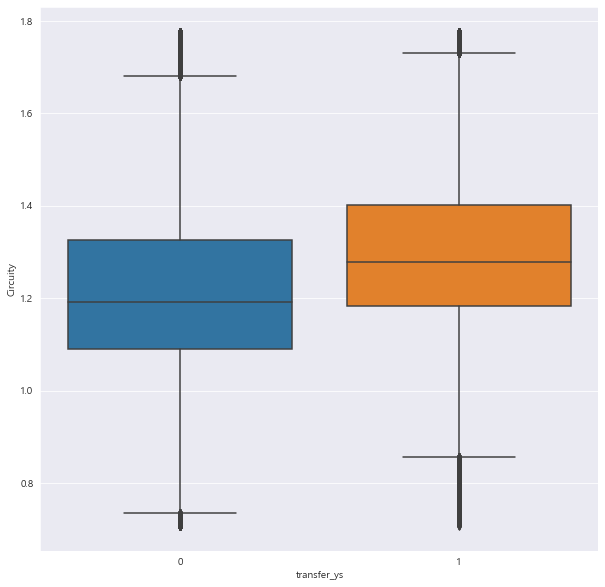

In [369]:
plt.figure(figsize = (10, 10))
sns.boxplot(y=df_path['Circuity'],  x= df_path['transfer_ys'])

In [370]:
import scipy.stats

In [371]:
scipy.stats.normaltest(line_number_two_nonzero['dt_time'])

NormaltestResult(statistic=7424.112886126455, pvalue=0.0)

In [372]:
scipy.stats.bartlett(wt_line_two['dt_time'], notwt_line_two['dt_time'])

BartlettResult(statistic=829.5646696253615, pvalue=2.015179725144145e-182)

In [373]:
scipy.stats.ttest_ind(wt_line_two['dt_time'], notwt_line_two['dt_time'], equal_var = False)

Ttest_indResult(statistic=-51.02859992724365, pvalue=0.0)

In [374]:
scipy.stats.ranksums(wt_line_two['dt_time'], notwt_line_two['dt_time'])

RanksumsResult(statistic=-60.673527337316344, pvalue=0.0)

In [375]:
print(scipy.stats.normaltest(line_number_two_nonzero['dt_time']))
print(scipy.stats.bartlett(wt_line_two['dt_time'], notwt_line_two['dt_time']))
print(scipy.stats.ttest_ind(wt_line_two['dt_time'], notwt_line_two['dt_time'], equal_var = False))
print(scipy.stats.ranksums(wt_line_two['dt_time'], notwt_line_two['dt_time']))

NormaltestResult(statistic=7424.112886126455, pvalue=0.0)
BartlettResult(statistic=829.5646696253615, pvalue=2.015179725144145e-182)
Ttest_indResult(statistic=-51.02859992724365, pvalue=0.0)
RanksumsResult(statistic=-60.673527337316344, pvalue=0.0)


## Con3
* 시각적으로 봤을 때, 출퇴근 시간에는 신도림 ~ 낙성대 구간 승차 후 교대 ~ 삼성에서 하차하는 사람들이 많았다.
* 출근 시간에 그렇지 않은 시간보다 분당 30m 씩 덜 가는 것으로 보이며 이는 통계적으로 유의한 차이가 있다고 말할 수 있다.
* 출근 시간에 해당 구역을 이동할 때, 혼잡한 지하철과 시간 지연이 예상되므로 이를 해결할 수 있는 다른 교통 수단에 대한 수요가 있을 법해 보인다.
* 다른 경로에서 똑같은 현상을 찾아볼 수 없을까?

### 4. 이동 거리 대비 시간 비율이 높다면 대중교통은 부족한 것으로 여긴다

In [ ]:
df_pre_com.info()

In [ ]:
df_time = df_pre_com[['card_name', 'on_area_name', 'on_dong', 'off_area_name', 'off_dong', 'total_distance' , 'total_time', 'on_hour', 'on_minute', 'off_hour', 'off_minute']]
df_time.head()

In [ ]:
#total time는 현실적으로 0이 나올 수 없지만 0이 나오는 경우가 있다. -> 제거
df_time.describe()

* 너무 짧은 이동시간이나(순간이동) 너무 긴 이동시간(9시간 가까이)들을 어떠한 기준으로 제거 할 것인가?
* 일단은 IQR을 사용하여 제거

In [379]:
time_iqr = df_time['total_time'].quantile(0.75) - df_time['total_time'].quantile(0.25)
outlier_step = time_iqr * 1.5

In [380]:
print(time_iqr)
print(outlier_step)

1495.0
2242.5


In [381]:
df_time['total_time'].quantile(0.25) - outlier_step

-1577.5

In [382]:
# IQR을 사용하되 하위 데이터는 10분 이상이라는 조건을 설정한다.
df_time_nonlier = df_time[(df_time['total_time'] < df_time['total_time'].quantile(0.75) + outlier_step) & (df_time['total_time'] > 600)]

In [ ]:
df_time_nonlier.describe()

In [384]:
df_time_nonlier['dt_ratio'] = df_time_nonlier['total_distance']/ (df_time_nonlier['total_time']/60)

C:\Users\user\AppData\Local\Temp/ipykernel_4496/490469653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_nonlier['dt_ratio'] = df_time_nonlier['total_distance']/ (df_time_nonlier['total_time']/60)


In [ ]:
df_time_nonlier.info()

In [ ]:
df_time_nonlier.describe()

In [ ]:
df_time_nonlier.describe()[['total_distance', 'total_time', 'dt_ratio']]

In [ ]:
# 출 퇴근 시간 고려하지 않은 전체 동 이동 데이터
# 평균 보다 이동 거리/ 이동 시간이 낮은 데이터만 추출
ratio_under_five = df_time_nonlier.sort_values(by='dt_ratio')[df_time_nonlier.sort_values(by='dt_ratio')['dt_ratio'] <= 315]
ratio_under_five.head()

In [389]:
ratio_under_five.reset_index(drop=True, inplace = True)

In [390]:
movement = []
length = len(ratio_under_five['card_name'])
for i in tqdm(range(length)):
    movement.append(str(ratio_under_five['on_dong'][i]) + '_' + str(ratio_under_five['off_dong'][i]))

  0%|          | 0/2941230 [00:00<?, ?it/s]

In [391]:
# 대학동 -> 낙성대동
# 노량진 1동 -> 노량진 1동
# 성산 2동 -> 서교동
# 종로 1,2,3,4가동 -> 회현동
# 서교동 -> 성산 2동
ratio_under_five['movement'] = movement
ratio_under_five['movement'].value_counts().head(20)

1121073_1121058    2931
1117072_1117072    2763
1114073_1114066    2666
1123064_1105053    2601
1123064_1122053    2590
1122053_1123064    2552
1101061_1102054    2489
1123064_1122059    2457
1123058_1123064    2451
1114066_1114073    2449
1101061_1114066    2312
1122066_1122066    2227
1122059_1123064    2170
1102055_1113075    2043
1105053_1123064    1989
1102054_1101061    1983
1114074_1114066    1947
1123064_1123058    1790
1102059_1102055    1772
1101063_1102052    1762
Name: movement, dtype: int64

In [392]:
# 대학동 -> 낙성대동
# 노량진 1동 -> 노량진 1동
# 성산 2동 -> 서교동
# 종로 1,2,3,4가동 -> 회현동
# 서교동 -> 성산 2동
ratio_under_five['movement'] = movement
ratio_under_five['movement'].value_counts().head(20)

1121073_1121058    2931
1117072_1117072    2763
1114073_1114066    2666
1123064_1105053    2601
1123064_1122053    2590
1122053_1123064    2552
1101061_1102054    2489
1123064_1122059    2457
1123058_1123064    2451
1114066_1114073    2449
1101061_1114066    2312
1122066_1122066    2227
1122059_1123064    2170
1102055_1113075    2043
1105053_1123064    1989
1102054_1101061    1983
1114074_1114066    1947
1123064_1123058    1790
1102059_1102055    1772
1101063_1102052    1762
Name: movement, dtype: int64

In [ ]:
#출 퇴근 시간 고려한 동 이동 데이터
wt_ruf = ratio_under_five[(ratio_under_five['on_hour'] >= 7) & (ratio_under_five['on_hour'] < 9)]
wt_ruf.head()

In [394]:
# 개봉3동 -> 가산동
# 개봉1동 -> 개봉1동
# 시흥2동 -> 시흥1동
# 신길7동 -> 여의동
# 길음1동 -> 종로 1,2,3,4가동
wt_ruf['movement'].value_counts().head(20)

1117065_1118051    689
1117072_1117072    674
1118058_1118057    599
1105053_1123064    568
1108066_1101061    533
1119069_1119054    501
1115072_1119054    480
1123076_1123075    475
3111055_1122066    452
1108082_1101061    447
1122066_1122066    446
1117065_1117055    428
1119056_1119054    428
1119055_1119054    419
1116073_1119054    406
1119073_1119054    391
1114066_1119054    367
1119061_1119054    365
1108085_1111056    345
1121069_1118051    334
Name: movement, dtype: int64

In [ ]:
#1117065_1118051
df_pre_com[(df_pre_com['on_dong'] == 1117065) & (df_pre_com['off_dong'] == 1118051)]

In [396]:
# 개봉3동 -> 가산동
# 개봉1동 -> 개봉1동
# 시흥2동 -> 시흥1동
# 신길7동 -> 여의동
# 길음1동 -> 종로 1,2,3,4가동
wt_ruf['movement'].value_counts().head(20)

1117065_1118051    689
1117072_1117072    674
1118058_1118057    599
1105053_1123064    568
1108066_1101061    533
1119069_1119054    501
1115072_1119054    480
1123076_1123075    475
3111055_1122066    452
1108082_1101061    447
1122066_1122066    446
1117065_1117055    428
1119056_1119054    428
1119055_1119054    419
1116073_1119054    406
1119073_1119054    391
1114066_1119054    367
1119061_1119054    365
1108085_1111056    345
1121069_1118051    334
Name: movement, dtype: int64

In [397]:
df_time_nonlier.shape

(5832532, 12)

In [ ]:
df_time_nonlier.describe()

In [399]:
df_time_nonlier_second = df_time_nonlier.copy()

In [400]:
df_time_nonlier_second['dt_ratio'] = df_time_nonlier['dt_ratio']/60

In [ ]:
df_time_nonlier_second.describe()

In [ ]:
# 출 퇴근 시간 고려하지 않은 전체 동 이동 데이터
# 평균 보다 이동 거리/ 이동 시간이 비교적 낮은 데이터만 추출
ratio_under_five = df_time_nonlier_second[df_time_nonlier_second['dt_ratio'] <= 5.25589].sort_values(by = 'dt_ratio')
ratio_under_five.describe()

In [403]:
ratio_under_five.reset_index(drop=True, inplace = True)

In [ ]:
ratio_under_five.head()

In [405]:
ratio_under_five.shape

(2948391, 12)

In [406]:
df_seoul = pd.read_csv(location + '/seoul_id.csv', encoding = 'euc-kr')
df_gyeongki = pd.read_csv(location + '/gyeonggi_id.csv', encoding = 'euc-kr')
print(df_seoul.shape)
print(df_gyeongki.shape)

(425, 3)
(551, 3)


In [407]:
ratio_under_five = pd.merge(ratio_under_five, df_seoul, left_on = 'on_dong', right_on = '행정구역번호', how = 'left')
ratio_under_five = pd.merge(ratio_under_five, df_seoul, left_on = 'off_dong', right_on = '행정구역번호', how = 'left')

In [408]:
ratio_under_five['route'] = ratio_under_five['읍면동명칭_x'] + ratio_under_five['읍면동명칭_y']

In [ ]:
ratio_under_five.head()

In [410]:
df_final = ratio_under_five[ratio_under_five['on_dong']!=ratio_under_five['off_dong']]
print(df_final.shape)

(2927973, 19)


<AxesSubplot:xlabel='on_hour', ylabel='Count'>

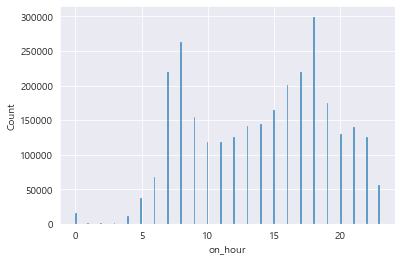

In [411]:
sns.histplot(data = df_final, x = 'on_hour')
#가장 이용자가 많은 시간 출근시간 7~9시 , 퇴근시간 17~19시

In [412]:
# 아침 7시~9시전 출근시간 시간 데이터 분류
df_onwork = df_final[(df_final['on_hour']==7)|(df_final['on_hour']==8)]
df_day = df_final[(df_final['on_hour']>=9)&(df_final['on_hour']<=16)]
df_offwork = df_final[(df_final['on_hour']==17)|(df_final['on_hour']==18)]
df_night = df_final[(df_final['on_hour']>=19)&(df_final['on_hour']<=23)]
print(df_onwork.shape)
print(df_day.shape)
print(df_offwork.shape)
print(df_night.shape)

(483208, 19)
(1166565, 19)
(518744, 19)
(626129, 19)


In [413]:
df_final['route'].value_counts().head(20)

대학동낙성대동           2932
성산2동서교동           2666
역삼1동화양동           2618
역삼1동서초3동          2592
서초3동역삼1동          2557
종로1·2·3·4가동회현동    2489
삼성1동역삼1동          2462
역삼1동반포3동          2457
서교동성산2동           2449
종로1·2·3·4가동서교동    2313
반포3동역삼1동          2172
명동신촌동             2049
화양동역삼1동           2001
회현동종로1·2·3·4가동    1983
상암동서교동            1947
역삼1동삼성1동          1802
광희동명동             1772
종로5·6가동소공동        1763
석관동공릉2동           1721
명동광희동             1612
Name: route, dtype: int64

In [414]:
df_final['route'].value_counts().head(5)

대학동낙성대동     2932
성산2동서교동     2666
역삼1동화양동     2618
역삼1동서초3동    2592
서초3동역삼1동    2557
Name: route, dtype: int64

In [415]:
#출근 시간대에 사람들이 많이 이용하는 구간 (구간 & 이용 빈도수)
df_onwork['route'].value_counts().head(30).reset_index()

,index,route
0,개봉3동가산동,689
1,시흥2동시흥1동,599
2,화양동역삼1동,570
3,길음1동종로1·2·3·4가동,533
4,신길7동여의동,501
5,신정4동여의동,481
6,세곡동수서동,476
7,삼선동종로1·2·3·4가동,447
8,개봉3동구로4동,430
9,당산2동여의동,428


In [416]:
#낮 시간대에 사람들이 많이 이용하는 구간 (구간 & 이용 빈도수)
df_day['route'].value_counts().head(30).reset_index()

,index,route
0,서초3동역삼1동,1353
1,삼성1동역삼1동,1348
2,역삼1동서초3동,1332
3,종로5·6가동소공동,1321
4,반포3동역삼1동,1294
5,역삼1동반포3동,1211
6,회현동종로1·2·3·4가동,1201
7,성산2동서교동,1200
8,서교동성산2동,1150
9,종로1·2·3·4가동회현동,1132


In [417]:
#퇴근 시간대에 사람들이 많이 이용하는 구간
df_offwork['route'].value_counts().head(30).reset_index()

,index,route
0,대학동낙성대동,884
1,역삼1동화양동,808
2,여의동서교동,643
3,성산2동서교동,623
4,역삼1동반포3동,618
5,종로1·2·3·4가동서교동,607
6,역삼1동서초3동,591
7,종로1·2·3·4가동회현동,578
8,삼성1동역삼1동,546
9,상암동서교동,517


In [418]:
#밤 시간대에 사람들이 많이 이용하는 구간
df_night['route'].value_counts().head(30).reset_index()

,index,route
0,역삼1동화양동,1002
1,대학동낙성대동,748
2,서교동성산2동,737
3,종로1·2·3·4가동서교동,730
4,명동광희동,725
5,종로1·2·3·4가동삼선동,669
6,명동서교동,626
7,종로1·2·3·4가동회현동,625
8,명동신촌동,552
9,역삼1동반포3동,541


In [419]:
on_onwork = df_onwork['읍면동명칭_x'].value_counts().head(15).reset_index()
on_onwork = on_onwork.rename(columns = {'index':'탑승한 지역', '읍면동명칭_x':'탑승자 수'})
on_onwork #출근 시간대 최다 탑승 지역

,탑승한 지역,탑승자 수
0,화곡1동,4882
1,서교동,3780
2,삼선동,3323
3,길음1동,3263
4,신정4동,3064
5,성산2동,2918
6,상도1동,2904
7,종암동,2793
8,우장산동,2775
9,신정3동,2632


In [420]:
off_onwork= df_onwork['읍면동명칭_y'].value_counts().head(15).reset_index()
off_onwork = off_onwork.rename(columns = {'index':'하차한 지역', '읍면동명칭_y':'하차 횟수'})
off_onwork #출근 시간대 최다 하차 지역

,하차한 지역,하차 횟수
0,종로1·2·3·4가동,18562
1,여의동,18094
2,역삼1동,16575
3,명동,9640
4,가산동,8250
5,소공동,8208
6,사직동,8037
7,삼성1동,7126
8,서초3동,6625
9,회현동,6560


In [421]:
on_offwork = df_offwork['읍면동명칭_x'].value_counts().head(15).reset_index()
on_offwork = on_offwork.rename(columns = {'index':'승차한 지역', '읍면동명칭_x':'승차 횟수'})
on_offwork #퇴근 시간대 최다 승차 지역

,승차한 지역,승차 횟수
0,종로1·2·3·4가동,18901
1,여의동,14433
2,역삼1동,14367
3,명동,10189
4,소공동,8963
5,서교동,8017
6,사직동,7249
7,종로5·6가동,7215
8,가산동,7071
9,회현동,7070


In [422]:
off_offwork = df_offwork['읍면동명칭_y'].value_counts().head(15).reset_index()
off_offwork = off_offwork.rename(columns = {'index':'하차한 지역', '읍면동명칭_y':'하차 횟수'})
off_offwork #퇴근 시간대 최다 하차 지역

,하차한 지역,하차 횟수
0,서교동,11304
1,종로1·2·3·4가동,8758
2,역삼1동,7343
3,명동,5440
4,화양동,4967
5,신촌동,4842
6,여의동,4547
7,회현동,4394
8,반포3동,4040
9,서초3동,3893


In [423]:
day_on = df_day['읍면동명칭_x'].value_counts().head(15).reset_index()
day_on

,index,읍면동명칭_x
0,종로1·2·3·4가동,30268
1,역삼1동,20080
2,명동,16305
3,서교동,16196
4,종로5·6가동,15905
5,여의동,15198
6,소공동,13949
7,회현동,13353
8,서초3동,12279
9,반포3동,12177


In [424]:
day_off = df_day['읍면동명칭_y'].value_counts().head(15).reset_index()
day_off

,index,읍면동명칭_y
0,종로1·2·3·4가동,37801
1,역삼1동,22393
2,서교동,21064
3,명동,20786
4,종로5·6가동,16472
5,회현동,15860
6,소공동,14980
7,신촌동,14356
8,여의동,13232
9,반포3동,12543


In [425]:
night_on = df_night['읍면동명칭_x'].value_counts().head(15).reset_index()
night_on

,index,읍면동명칭_x
0,종로1·2·3·4가동,29271
1,서교동,18526
2,역삼1동,18217
3,명동,17119
4,여의동,14262
5,소공동,8126
6,신촌동,7902
7,서초3동,7470
8,회현동,7329
9,광희동,7251


In [426]:
night_off = df_night['읍면동명칭_y'].value_counts().head(15).reset_index()
night_off

,index,읍면동명칭_y
0,서교동,10360
1,역삼1동,5445
2,화양동,5305
3,종로1·2·3·4가동,4831
4,회현동,4704
5,사당1동,4418
6,명동,4396
7,화곡1동,4274
8,광희동,4229
9,신촌동,4088


In [427]:
dict_on_onwork = {'동 이름':1}
for i in range(len(on_onwork)):
    dict_on_onwork[on_onwork.loc[i,'탑승한 지역']]=on_onwork.loc[i,'탑승자 수']
dict_on_onwork

{'동 이름': 1,
 '화곡1동': 4882,
 '서교동': 3780,
 '삼선동': 3323,
 '길음1동': 3263,
 '신정4동': 3064,
 '성산2동': 2918,
 '상도1동': 2904,
 '종암동': 2793,
 '우장산동': 2775,
 '신정3동': 2632,
 '연희동': 2567,
 '사당1동': 2487,
 '개봉3동': 2399,
 '답십리1동': 2377,
 '송천동': 2367}

In [428]:
dict_off_onwork = {'동 이름':1}
for i in range(len(off_onwork)):
    dict_off_onwork[off_onwork.loc[i,'하차한 지역']]=off_onwork.loc[i,'하차 횟수']
dict_off_onwork

{'동 이름': 1,
 '종로1·2·3·4가동': 18562,
 '여의동': 18094,
 '역삼1동': 16575,
 '명동': 9640,
 '가산동': 8250,
 '소공동': 8208,
 '사직동': 8037,
 '삼성1동': 7126,
 '서초3동': 6625,
 '회현동': 6560,
 '서초2동': 5706,
 '종로5·6가동': 5341,
 '서교동': 5046,
 '신촌동': 4659,
 '성수2가3동': 4322}

In [429]:
dict_on_offwork = {'동 이름':1}
for i in range(len(on_offwork)):
    dict_on_offwork[on_offwork.loc[i,'승차한 지역']]=on_offwork.loc[i,'승차 횟수']
dict_on_offwork

{'동 이름': 1,
 '종로1·2·3·4가동': 18901,
 '여의동': 14433,
 '역삼1동': 14367,
 '명동': 10189,
 '소공동': 8963,
 '서교동': 8017,
 '사직동': 7249,
 '종로5·6가동': 7215,
 '가산동': 7071,
 '회현동': 7070,
 '삼성1동': 6559,
 '서초3동': 6304,
 '신촌동': 5523,
 '서초2동': 5128,
 '광희동': 4584}

In [430]:
dict_off_offwork = {'동 이름':1}
for i in range(len(off_offwork)):
    dict_off_offwork[off_offwork.loc[i,'하차한 지역']]=off_offwork.loc[i,'하차 횟수']
dict_off_offwork

{'동 이름': 1,
 '서교동': 11304,
 '종로1·2·3·4가동': 8758,
 '역삼1동': 7343,
 '명동': 5440,
 '화양동': 4967,
 '신촌동': 4842,
 '여의동': 4547,
 '회현동': 4394,
 '반포3동': 4040,
 '서초3동': 3893,
 '사당1동': 3603,
 '화곡1동': 3227,
 '혜화동': 3175,
 '잠실6동': 3165,
 '신도림동': 3094}

In [431]:
dict_on_day = {'동 이름':1}
for i in range(len(day_on)):
    dict_on_day[day_on.loc[i,'index']]=day_on.loc[i,'읍면동명칭_x']
dict_on_day

{'동 이름': 1,
 '종로1·2·3·4가동': 30268,
 '역삼1동': 20080,
 '명동': 16305,
 '서교동': 16196,
 '종로5·6가동': 15905,
 '여의동': 15198,
 '소공동': 13949,
 '회현동': 13353,
 '서초3동': 12279,
 '반포3동': 12177,
 '신촌동': 11717,
 '사직동': 9735,
 '삼성1동': 9133,
 '광희동': 8807,
 '서초2동': 8466}

In [432]:
dict_off_day = {'동 이름':1}
for i in range(len(day_off)):
    dict_off_day[day_off.loc[i,'index']]=day_off.loc[i,'읍면동명칭_y']
dict_off_day

{'동 이름': 1,
 '종로1·2·3·4가동': 37801,
 '역삼1동': 22393,
 '서교동': 21064,
 '명동': 20786,
 '종로5·6가동': 16472,
 '회현동': 15860,
 '소공동': 14980,
 '신촌동': 14356,
 '여의동': 13232,
 '반포3동': 12543,
 '서초3동': 12221,
 '사직동': 11545,
 '삼성1동': 10808,
 '광희동': 10547,
 '잠실6동': 9397}

In [433]:
dict_on_night = {'동 이름':1}
for i in range(len(night_on)):
    dict_on_night[night_on.loc[i,'index']]=night_on.loc[i,'읍면동명칭_x']
dict_on_night

{'동 이름': 1,
 '종로1·2·3·4가동': 29271,
 '서교동': 18526,
 '역삼1동': 18217,
 '명동': 17119,
 '여의동': 14262,
 '소공동': 8126,
 '신촌동': 7902,
 '서초3동': 7470,
 '회현동': 7329,
 '광희동': 7251,
 '사직동': 7216,
 '삼성1동': 7182,
 '종로5·6가동': 7096,
 '서초2동': 7037,
 '가산동': 6892}

In [434]:
dict_off_night = {'동 이름':1}
for i in range(len(night_off)):
    dict_off_night[night_off.loc[i,'index']]=night_off.loc[i,'읍면동명칭_y']
dict_off_night

{'동 이름': 1,
 '서교동': 10360,
 '역삼1동': 5445,
 '화양동': 5305,
 '종로1·2·3·4가동': 4831,
 '회현동': 4704,
 '사당1동': 4418,
 '명동': 4396,
 '화곡1동': 4274,
 '광희동': 4229,
 '신촌동': 4088,
 '송천동': 4052,
 '삼선동': 3855,
 '반포3동': 3630,
 '상도1동': 3629,
 '여의동': 3562}

In [435]:
# Wordcloud 설치 이슈로 인해 이후 코드는 동봉된 파일 확인 요망

In [436]:
# Wordcloud Point

## Con4
* 초당 이동거리 = 총 이동거리/ 총 이동시간
* 일부 구간은 다른 지역보다 초당 이동거리가 낮게 나오는 지역에서 수요가 있을 법한 지역을 찾을 수 있을 것이다.

### 시간을 고려하지 않고 분석 했을 때
* 대학동 -> 낙성대동/ 노량진 1동 -> 노량진 1동 / 성산 2동 -> 서교동/ 종로 1,2,3,4가동 -> 회현동 / 서교동 -> 성산 2동
* 상기 지역들은 초당 이동거리가 평균 보다 적은 경우에 이동이 가장 많이 일어나는 동 경로
* 대학동 -> 낙성대동 : 거리가 멀지 않음에도 서울대학교에 등교하는 학생들이 많아 시간이 오래 걸리는 것으로 추측
* 노량진 1동 -> 노량진 1동 : 노량진역 일대가 유동인구가 많고 지하철역과 버스역이 인근에 접해있어 이용객이 많은 것으로 추정(수요가 있다고 판단하기는 힘들다)
* 종로 1,2,3,4가동 -> 회현동 : 대부분의 대중 교통 경로가 서울 시내인 종각역, 을지로입구역, 회회현역을 가로 지르는 혼잡한 구역을 지나가는 가는 것이 이유로 추측됨(대체 경로 제공은 가능할 듯)
* 성산 2동 -> 서교동 : 합정역 -> 홍대 입구역 -> 신촌역 -> 이대역으로 이어지는 도로구간이 혼잡해서 그런것으로 파악(가까운 거리로 수요가 있다고 판단하기 어려움)

### 출퇴근 시간을 고려해서 분석했을 때
* 개봉3동 -> 가산동/ 개봉1동 -> 개봉1동/ 시흥2동 -> 시흥1동/ 신길7동 -> 여의동/ 길음1동 -> 종로 1,2,3,4가동
* 개봉3동 -> 가산동 : 가산동에 사무실이 많아 출근 경로로 예상되어 지연 될 가능성 높음. 해당지역 약 5km으로 먼 거리는 아니나 한번에 갈 수 있는 대중교통이 없음(한번에 갈 수 있는 경로를 제공하면 수요가 있을 것으로 예측됨)
* 개봉1동 -> 개봉1동 : 이유 불명(같은 지역으로 수요가 있을 것으로 예측되지는 않음)
* 시흥2동 -> 시흥1동 : 이유 불명(같은 지역으로 수요가 있을 것으로 예측되지는 않음)
* 신길7동 -> 여의동 : 출근길 교통 혼잡 및 신길, 대방, 노량진 역으로 가는 구역을 지나가는 것이 이유로 추측 됨. 다만 이동 시간이 오래걸리지는 않고, 환승 없이 이동이 가능 한 수단이 많다.(수요가 있을 것이라고 판단하기는 어렵다)
* 길음1동 -> 종로 1,2,3,4가동 : 종로구에 사무실이 많아 출근길이 혼잡지역으로 예상됨, 지하철을 타면 환승을 할 수 밖에 없고, 버스를 타면 환승없이 이동이 가능하나 대부분의 노선이 같은 경로를 사용(대체 경로 제공 가능할 것으로 판단)

###  5. 야간에 지하철이 운행을 중단하는 구간에 모빌리티 서비스 수요가 있는지 확인한다

* 막차 : 종착역 도착 기준으로 00:00시까지
* 12시~1시(포함) 하차를 막차의 기준으로 한다.
* 2시 이후 승,하차 기록이 있는 데이터는 신뢰할 수 없다

In [437]:
# 막차인지 어떻게 확인 할 것인가
df_pre_com['off_hour'].value_counts()

8     866526
18    670691
19    612856
9     535205
17    475241
7     418456
16    416393
20    382586
22    352614
15    351474
21    346585
10    334530
13    329985
14    322266
11    303593
12    301059
23    228714
6     164957
0      93758
5      61191
4      13162
1      12082
2       3586
3       2334
Name: off_hour, dtype: int64

* 종착역 : 신도림역, 서울대입구역, 홍대입구역, 수유역, 노원역, 잠실역, 당산역, 낙성대, 까치산역       
* 비 종착역 : 신림역, 사당역, 건대입구역, 쌍문역, 구로디지털단지역, 연신내역, 천호, 미아사거리, 합정, 신대방역,  낙성대,

In [438]:
top_off_20 = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2)]['off_area_name'].value_counts().head(20)

In [439]:
df_top_off_20 = pd.DataFrame(top_off_20).reset_index()
df_top_off_20.columns = ['off_area_name', 'count']
df_top_off_20

,off_area_name,count
0,신림역,1365
1,신도림역,1225
2,사당역,991
3,건대입구역,858
4,서울대입구역,845
5,쌍문역,815
6,구로디지털단지역,798
7,홍대입구역,776
8,연신내역,718
9,수유역,628


In [440]:
df_top_off_20['off_area_name']

0          신림역
1         신도림역
2          사당역
3        건대입구역
4       서울대입구역
5          쌍문역
6     구로디지털단지역
7        홍대입구역
8         연신내역
9          수유역
10         노원역
11         잠실역
12         당산역
13         천호역
14      미아사거리역
15         합정역
16        낙성대역
17        신대방역
18         창동역
19        까치산역
Name: off_area_name, dtype: object

In [441]:
top_off_lon = [df_pre_com[df_pre_com['off_area_name'] == df_top_off_20['off_area_name'][i]]['off_lon'].iloc[0] for i in range(len(df_top_off_20['off_area_name']))]
top_off_lat = [df_pre_com[df_pre_com['off_area_name'] == df_top_off_20['off_area_name'][i]]['off_lat'].iloc[0] for i in range(len(df_top_off_20['off_area_name']))]

In [442]:
top_off_lon

[126.929731,
 126.891508,
 126.981664,
 127.071082,
 126.95273,
 127.034745,
 126.901596,
 126.92375,
 126.920904,
 127.025505,
 127.060568,
 127.100164,
 126.900525,
 127.123178,
 127.030084,
 126.914496,
 126.963508,
 126.913306,
 127.047672,
 126.846421]

In [443]:
for name in list(df_top_off_20['off_area_name']):
    print(name)

신림역
신도림역
사당역
건대입구역
서울대입구역
쌍문역
구로디지털단지역
홍대입구역
연신내역
수유역
노원역
잠실역
당산역
천호역
미아사거리역
합정역
낙성대역
신대방역
창동역
까치산역


In [444]:
folium.IFrame

branca.element.IFrame

In [445]:
#야간에 하차가 많이 일어나는 Top 10의 지도그리기
map_off = folium.Map(location = [37.512, 126.950], zoom_start = 12)

for lat, lon, name in  tqdm(zip(top_off_lat, top_off_lon, list(df_top_off_20['off_area_name']))):
    iframe = folium.IFrame(name)
    popup = folium.Popup(iframe, min_width = 80, max_width = 100)
    folium.Marker([lat, lon], popup=popup).add_to(map_off)
    
map_off

0it [00:00, ?it/s]

In [446]:
map_off.save('map.html')

In [ ]:
df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2)]

* 하차가 많이 일어나는 Top10의 출발지를 조사

In [448]:
# 신림역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_sinlim = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '신림역')]['on_area_name'].value_counts().head(10)
to_sinlim

강남역         203
홍대입구역        99
사당역          64
합정역          51
잠실역          43
선릉역          40
삼성역          38
구로디지털단지역     37
교대역          34
신촌역          31
Name: on_area_name, dtype: int64

In [449]:
sns.set_style('darkgrid')

In [450]:
# 그래프 속성
mpl.rc('font', family = 'Malgun Gothic')
mpl.rc('axes', unicode_minus = False)

Text(0, 0.5, 'Count')

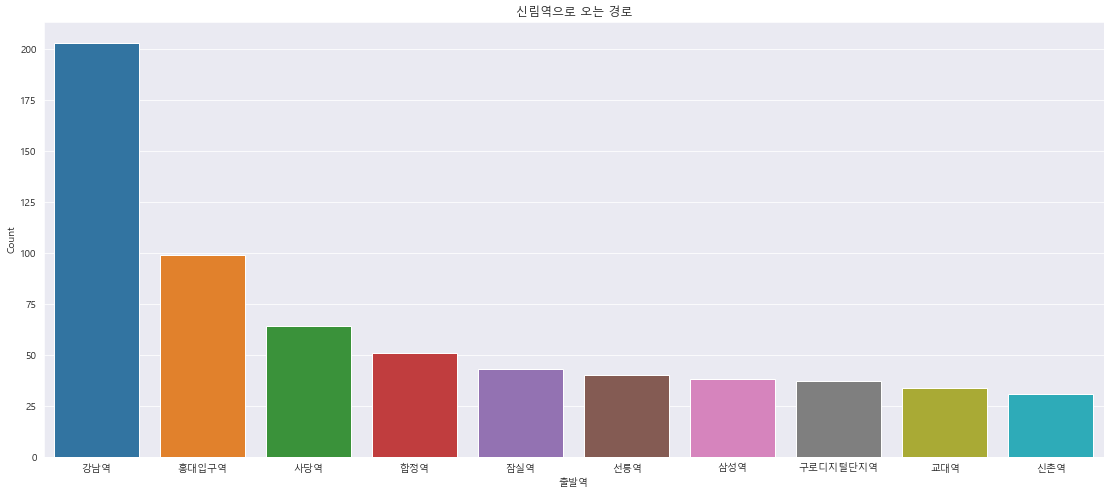

In [451]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_sinlim).reset_index())
plt.title('신림역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [452]:
# 신도림에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_sindolim = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '신도림역')]['on_area_name'].value_counts().head(10)
to_sindolim

홍대입구역       122
강남역         109
합정역          71
신촌역          57
사당역          36
을지로입구역       35
구로디지털단지역     31
종각역          31
역삼역          28
신림역          25
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

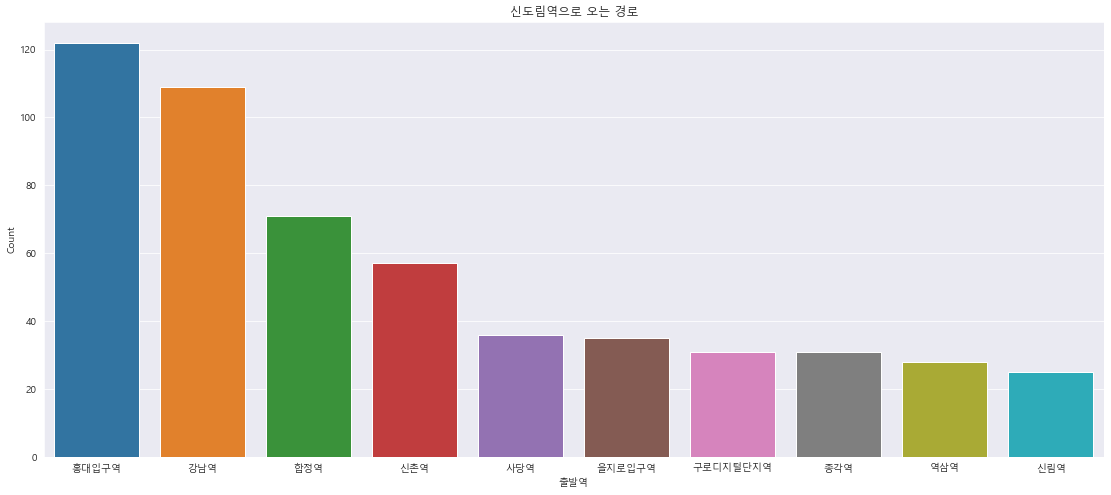

In [453]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_sindolim).reset_index())
plt.title('신도림역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [454]:
# 사당역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_sadang = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '사당역')]['on_area_name'].value_counts().head(10)
to_sadang

강남역           76
혜화역           37
홍대입구역         33
교대역           28
신림역           26
선릉역           24
충무로역          24
삼성역           22
동대문역사문화공원역    21
신촌역           20
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

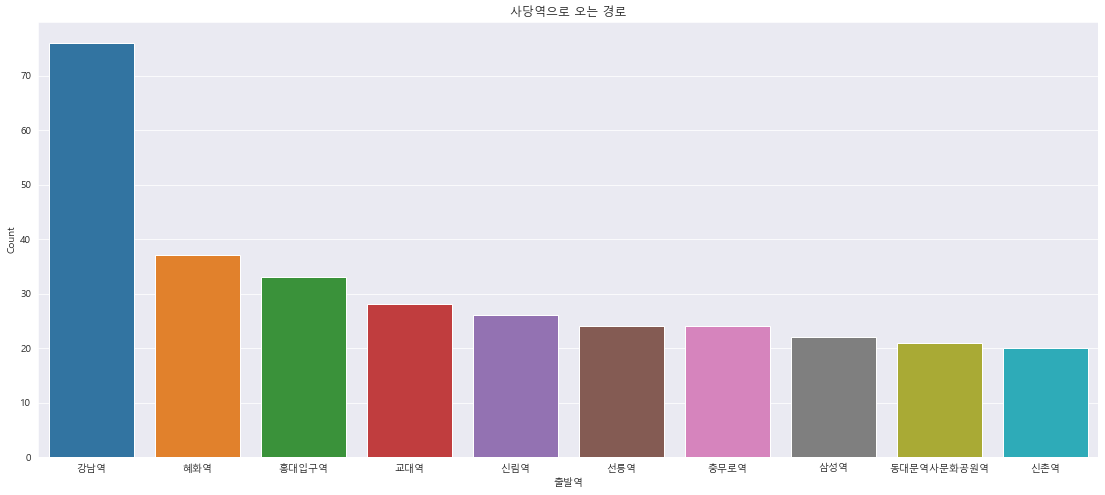

In [455]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_sadang).reset_index())
plt.title('사당역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [456]:
# 건대입구역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_gundae = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '건대입구역')]['on_area_name'].value_counts().head(10)
to_gundae

강남역           68
홍대입구역         47
신촌역           29
동대문역사문화공원역    25
을지로입구역        24
잠실역           23
강변역           23
사당역           21
왕십리역          19
논현역           18
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

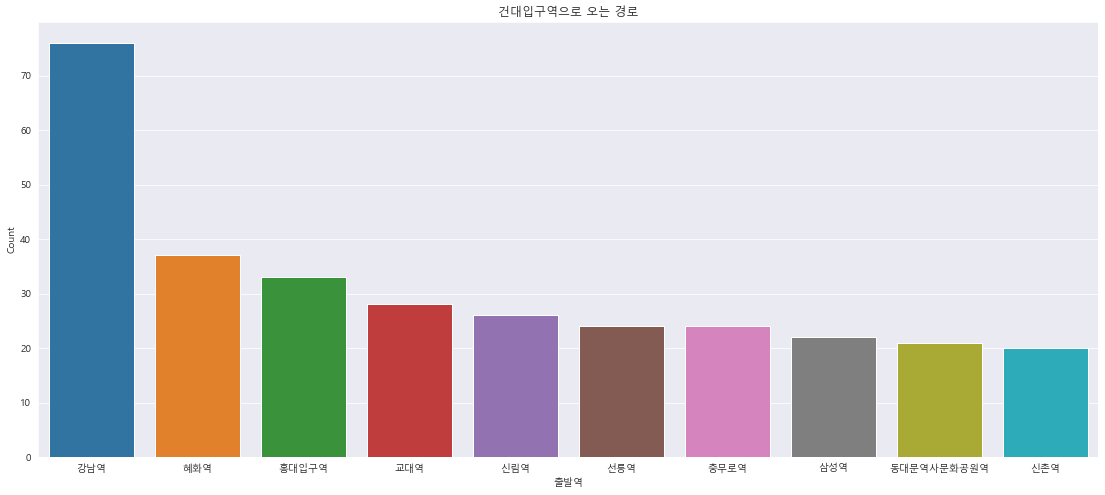

In [457]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_sadang).reset_index())
plt.title('건대입구역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [458]:
# 서울대입구역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_seouluniv = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '서울대입구역')]['on_area_name'].value_counts().head(10)
to_seouluniv

강남역      161
사당역       53
교대역       45
삼성역       36
홍대입구역     32
역삼역       30
선릉역       24
합정역       22
신림역       22
건대입구역     21
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

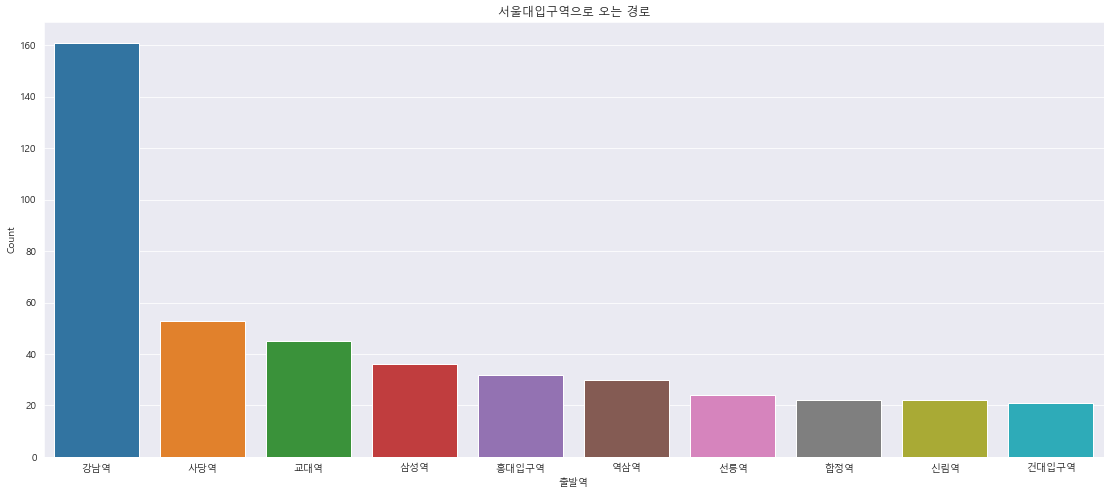

In [459]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_seouluniv).reset_index())
plt.title('서울대입구역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [460]:
# 쌍문역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_ssangmoon = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '쌍문역')]['on_area_name'].value_counts().head(10)
to_ssangmoon

명동역           31
홍대입구역         26
혜화역           24
수유역.강북구청      21
동대문역사문화공원역    21
충무로역          20
사당역           19
서울역           17
신촌역           17
동대문역          16
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

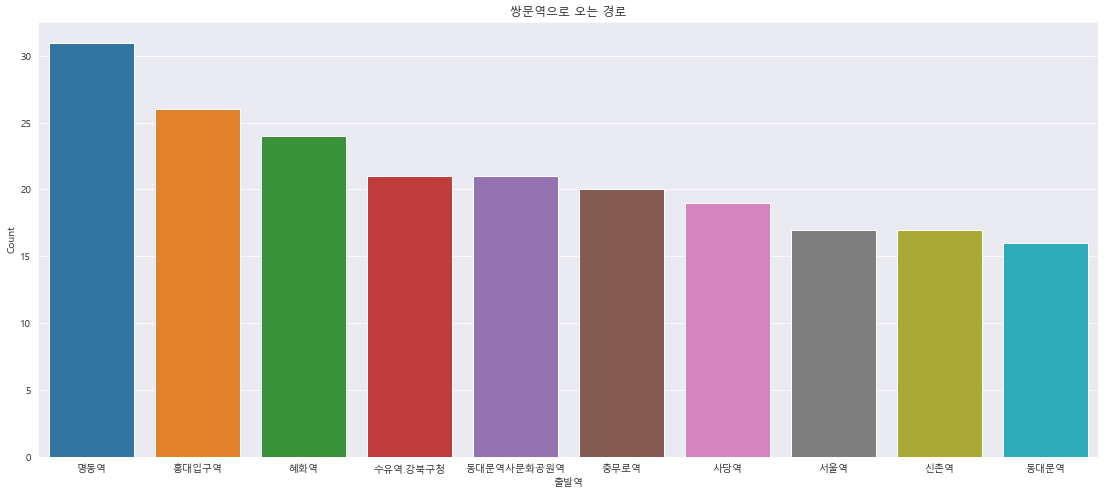

In [461]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_ssangmoon).reset_index())
plt.title('쌍문역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [462]:
# 구로디지털단지역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_gurodigit = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '구로디지털단지역')]['on_area_name'].value_counts().head(10)
to_gurodigit

강남역           76
홍대입구역         60
합정역           35
을지로입구역        26
신촌역           23
선릉역           21
교대역           21
동대문역사문화공원역    16
신도림역          16
서울대입구역        15
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

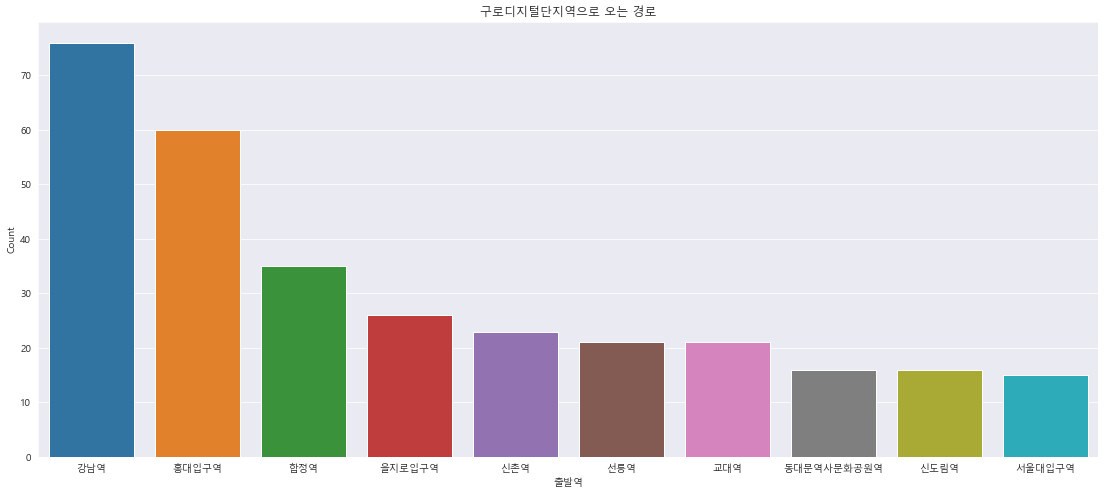

In [463]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_gurodigit).reset_index())
plt.title('구로디지털단지역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [464]:
# 연신내역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_yoensin = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '연신내역')]['on_area_name'].value_counts().head(10)
to_yoensin 

합정역       27
압구정역      26
종로3가역     25
충무로역      21
상수역       18
신사역       17
건대입구역     16
안국역       15
경복궁역      15
을지로3가역    14
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

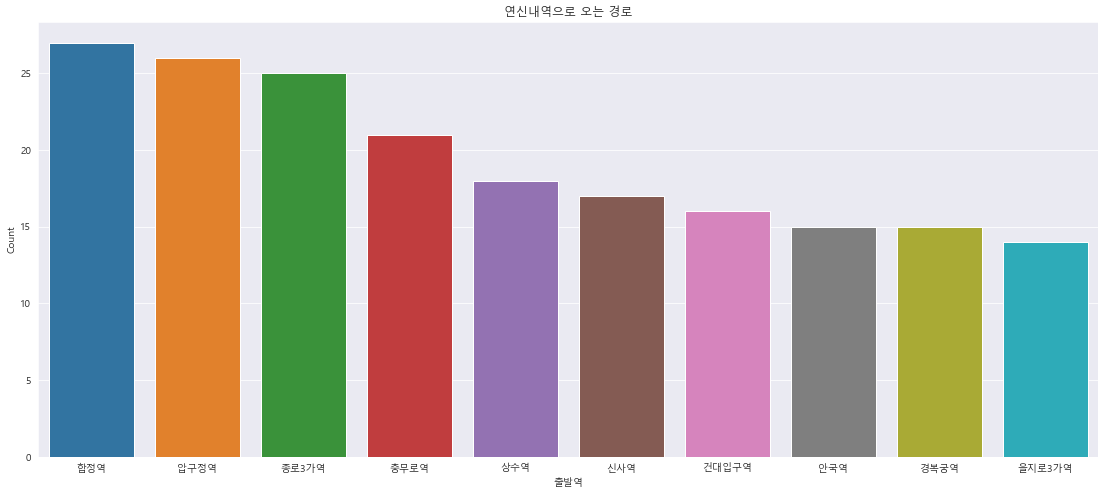

In [465]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_yoensin).reset_index())
plt.title('연신내역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

In [466]:
# 수유역에서 야간에 하차하는 사람들은 대략적으로 어디서 오는가
to_suyu = df_pre_com[(df_pre_com['off_hour'] >= 0) & (df_pre_com['off_hour'] < 2) & (df_pre_com['off_area_name'] == '수유역')]['on_area_name'].value_counts().head(10)
to_suyu

홍대입구역         39
충무로역          30
명동역           29
노원역           27
동대문역사문화공원역    24
사당역           24
서울역           20
혜화역           17
강남역           12
창동역           12
Name: on_area_name, dtype: int64

Text(0, 0.5, 'Count')

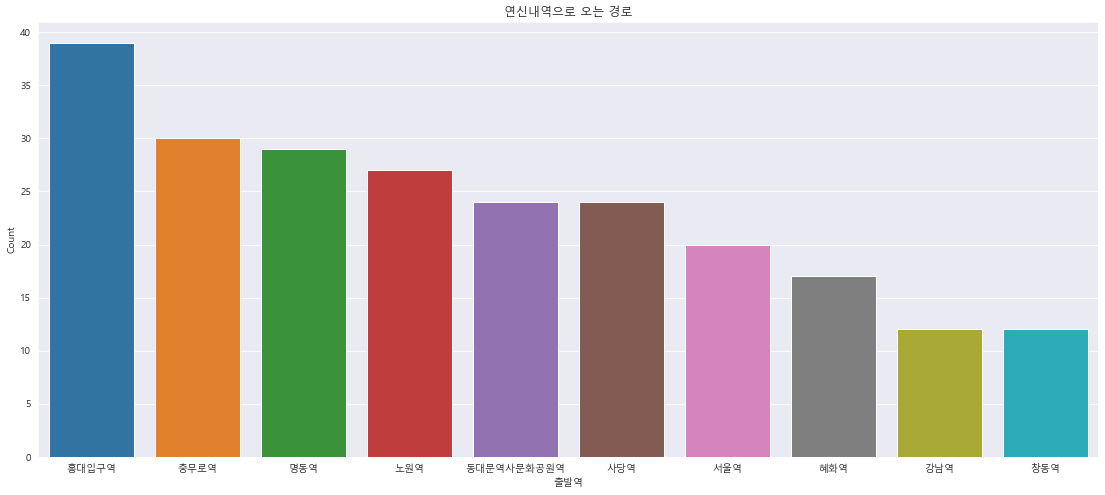

In [467]:
plt.figure(figsize = (19, 8))
sns.barplot(x='index', y='on_area_name', data = pd.DataFrame(to_suyu).reset_index())
plt.title('연신내역으로 오는 경로')
plt.xlabel('출발역')
plt.ylabel('Count')

## Con5
- 홍대입구역, 신촌, 합정역에서 에서 신림, 사당, 서울대입구 역 쪽으로 오는 사람들이 상위권에 자리잡고 있다. 이들에게서 수요가 생기지 않을까
- 역으로, 홍대입구역에서 건대입구, 사당, 신림, 서울대입구 역으로 오는 사람들도 상위권에 자리잡고 있다. 이들에게서도 수요가 생기지 않을까
- 홍대입구 ~ 수유 구간은 지하철을 타면 한번 갈아타야 하며, 버스가 있긴하지만 지하철에 비해 시간이 오래 걸린다. 홍대입구 ~ 수유 구간에 수요가 있지 않을까


- 종착역인 신도림역, 홍대입구역, 잠실역, 당산역은 인구 거주 지역이기보다 다른 교통수단으로 환승하려는 인원이 많을 것으로 짐작된다. 이를 뒷받침할 데이터가 있지 않을까 

###  6. 환승을 많이 하는 사람들에게 모빌리티 서비스에 대한 수요가 있다고 판단한다.

In [468]:
df_pre_com.reset_index(inplace = True, drop = True)

In [ ]:
df_pre_com.info()

In [470]:
df_path = df_pre_com[['card_name', 'Bus', 'Subway', 'on_area_name', 'on_dong', 'off_area_name', 'off_dong','no_transfer', 'on_hour', 'on_minute', 'off_hour', 'off_minute', 'Circuity']]

In [471]:
df_path['no_transfer'].value_counts()

0    5433357
1    1848852
2     285140
3      26985
4       5510
Name: no_transfer, dtype: int64

In [472]:
transfer = []
for i in tqdm(range(0, len(df_pre_com['card_name']))):
    if (df_pre_com['Bus'][i] == True) & (df_pre_com['Subway'][i] == True):
        transfer.append(str(1))
    else:
        transfer.append(str(0))

  0%|          | 0/7599844 [00:00<?, ?it/s]

In [473]:
df_path['transfer_ys'] = transfer

C:\Users\user\AppData\Local\Temp/ipykernel_4496/4234088220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_path['transfer_ys'] = transfer


In [474]:
df_path['transfer_ys'].value_counts()

0    6529190
1    1070654
Name: transfer_ys, dtype: int64

In [ ]:
df_path.sort_values(by = 'Circuity', ascending=False).head()

In [476]:
#한번이라도 환스을 한 경험이 있는 경우 vs # 한번도 환승을 해본 경험이 없는 경우
# 5433357 vs 2166487
df_path['no_transfer'].value_counts()

0    5433357
1    1848852
2     285140
3      26985
4       5510
Name: no_transfer, dtype: int64

In [477]:
#stop

In [478]:
trans_n = df_path[df_path['transfer_ys'] == '0']

In [ ]:
trans_n.describe()

In [ ]:
trans_n.describe()[['Circuity']]

In [481]:
trans_y = df_path[df_path['transfer_ys'] == '1']

In [ ]:
trans_y.describe()

In [ ]:
trans_y.describe()[['Circuity']]

<AxesSubplot:xlabel='transfer_ys', ylabel='Circuity'>

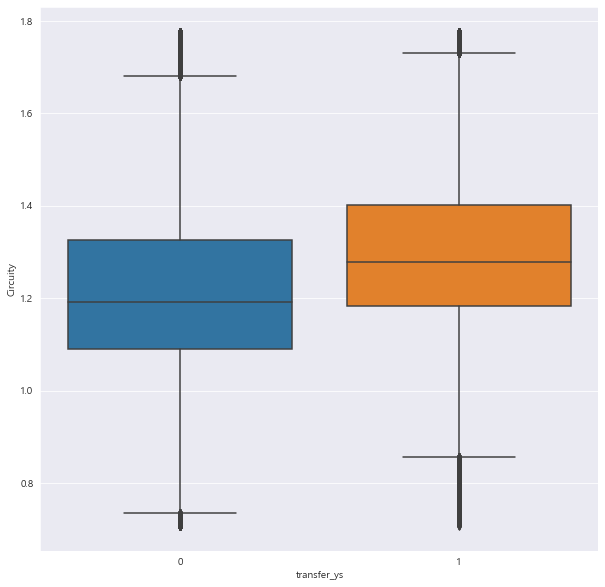

In [484]:
plt.figure(figsize = (10, 10))
sns.boxplot(y=df_path['Circuity'],  x= df_path['transfer_ys'])

In [485]:
scipy.stats.normaltest(df_path['Circuity'])

NormaltestResult(statistic=571775.7575807455, pvalue=0.0)

In [486]:
scipy.stats.bartlett(trans_n['Circuity'], trans_y['Circuity'])

BartlettResult(statistic=12863.816666540071, pvalue=0.0)

In [487]:
# 환승여부에 따른 Circuity 차이가 있다
scipy.stats.ttest_ind(trans_n['Circuity'], trans_y['Circuity'], equal_var = False)

Ttest_indResult(statistic=-462.54548202333774, pvalue=0.0)

In [488]:
# 환승여부에 따른 Circuity 차이가 있다
scipy.stats.ranksums(trans_n['Circuity'], trans_y['Circuity'])

RanksumsResult(statistic=-490.1412210617904, pvalue=0.0)

In [489]:
print(scipy.stats.normaltest(df_path['Circuity']))
print(scipy.stats.bartlett(trans_n['Circuity'], trans_y['Circuity']))
print(scipy.stats.ttest_ind(trans_n['Circuity'], trans_y['Circuity'], equal_var = False))
print(scipy.stats.ranksums(trans_n['Circuity'], trans_y['Circuity']))

NormaltestResult(statistic=571775.7575807455, pvalue=0.0)
BartlettResult(statistic=12863.816666540071, pvalue=0.0)
Ttest_indResult(statistic=-462.54548202333774, pvalue=0.0)
RanksumsResult(statistic=-490.1412210617904, pvalue=0.0)


In [490]:
trans_y_move = trans_y[['card_name', 'on_area_name', 'on_dong', 'off_area_name','off_dong', 'on_hour', 'off_hour','no_transfer', 'Circuity']]

In [ ]:
trans_y_move.head()

In [492]:
trans_y.reset_index(drop = True, inplace = True)

In [493]:
trans_movement = []
length = len(trans_y['card_name'])
for i in tqdm(range(length)):
    path = str(trans_y['on_dong'][i]) + '_' + str(trans_y['off_dong'][i])
    trans_movement.append((path))

  0%|          | 0/1070654 [00:00<?, ?it/s]

In [494]:
trans_y['movement'] = trans_movement

C:\Users\user\AppData\Local\Temp/ipykernel_4496/444122341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_y['movement'] = trans_movement


In [495]:
# 대학동 - > 역삼1동
# 역삼1동 -> 대학동
# 미성동 -> 역삼1동
# 삼전동 -> 역삼1동
# 역삼1동 -> 서림동
pd.DataFrame(trans_y['movement'].value_counts().head(5))

,movement
1121073_1123064,1404
1123064_1121073,798
1121083_1123064,783
1124064_1123064,757
1123064_1121066,718


In [ ]:
trans_y.head()

In [ ]:
trans_y[trans_y['movement'] == '1121073_1123064'].describe()

In [ ]:
trans_y[trans_y['movement'] == '1121073_1123064'].head()

In [499]:
daehak_yeoksam = pd.DataFrame(trans_y[trans_y['movement'] == '1121073_1123064']['on_hour'].value_counts()).reset_index()
daehak_yeoksam.columns = ['Hour', 'Count']

<AxesSubplot:xlabel='Hour', ylabel='Count'>

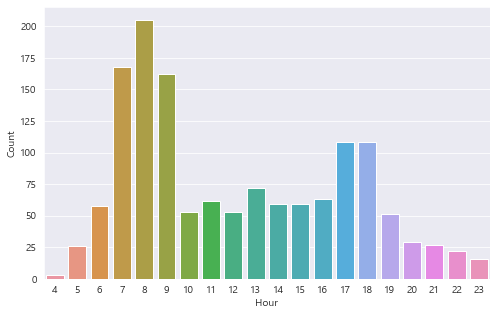

In [500]:
plt.figure(figsize=(8, 5))
sns.barplot(data=daehak_yeoksam, x='Hour', y='Count')

In [ ]:
trans_y[(trans_y['movement'] == '1123064_1121073')].head()

In [ ]:
trans_y[trans_y['movement'] == '1123064_1121073'].describe()

In [503]:
trans_y[trans_y['movement'] == '1123064_1121073']['on_hour'].value_counts()

21    86
22    69
18    69
20    61
19    59
8     56
17    54
10    52
9     40
13    37
15    35
12    34
23    33
14    28
7     25
16    24
11    23
6      7
5      6
Name: on_hour, dtype: int64

In [504]:
yeoksam_daehak = trans_y[trans_y['movement'] == '1123064_1121073']['on_hour'].value_counts().reset_index()
yeoksam_daehak.columns = ['Hour', 'Count']

In [505]:
yeoksam_daehak

,Hour,Count
0,21,86
1,22,69
2,18,69
3,20,61
4,19,59
5,8,56
6,17,54
7,10,52
8,9,40
9,13,37


<AxesSubplot:xlabel='Hour', ylabel='Count'>

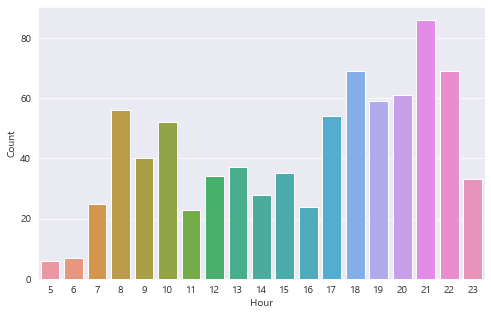

In [506]:
plt.figure(figsize=(8, 5))
sns.barplot(data=yeoksam_daehak, x='Hour', y='Count')

In [507]:
misung_yeoksam = trans_y[trans_y['movement'] == '1121083_1123064']['on_hour'].value_counts().reset_index()
misung_yeoksam.columns = ['Hour', 'Count']

<AxesSubplot:xlabel='Hour', ylabel='Count'>

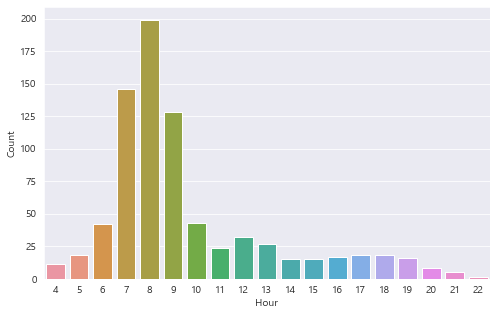

In [508]:
plt.figure(figsize=(8, 5))
sns.barplot(data=misung_yeoksam, x='Hour', y='Count')

In [509]:
yeoksam_serlim = trans_y[trans_y['movement'] == '1123064_1121066']['on_hour'].value_counts().reset_index()
yeoksam_serlim.columns = ['Hour', 'Count']

<AxesSubplot:xlabel='Hour', ylabel='Count'>

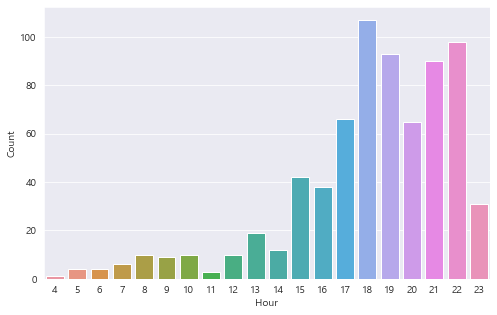

In [510]:
plt.figure(figsize=(8, 5))
sns.barplot(data=yeoksam_serlim, x='Hour', y='Count')